# Анализ результатов АБ-теста

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.sandbox.stats.multicomp import multipletests 
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

В данном задании вам нужно будет

    проанализировать АБ тест, проведенный на реальных пользователях Яндекса
    подтвердить или опровергнуть наличие изменений в пользовательском поведении между контрольной (control) и тестовой (exp) группами
    определить характер этих изменений и практическую значимость вводимого изменения
    понять, какая из пользовательских групп более всего проигрывает / выигрывает от тестируемого изменения (локализовать изменение)

Описание данных:

    userID: уникальный идентификатор пользователя
    browser: браузер, который использовал userID
    slot: в каком статусе пользователь участвовал в исследовании (exp = видел измененную страницу, control = видел неизменную страницу)
    n_clicks: количество кликов, которые пользоваль совершил за n_queries
    n_queries: количество запросов, который совершил userID, пользуясь браузером browser
    n_nonclk_queries: количество запросов пользователя, в которых им не было совершено ни одного клика

Обращаем ваше внимание, что не все люди используют только один браузер, поэтому в столбце userID есть повторяющиеся идентификаторы. В предлагаемых данных уникальным является сочетание userID и browser.

In [2]:
data = pd.read_csv('ab_browser_test.csv')

In [3]:
data.head()

,userID,browser,slot,n_clicks,n_queries,n_nonclk_queries
0,1,Browser #2,exp,23,32,19
1,3,Browser #4,exp,3,4,2
2,5,Browser #4,exp,29,35,16
3,6,Browser #4,control,12,6,0
4,7,Browser #4,exp,54,68,30


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 566134 entries, 0 to 566133
Data columns (total 6 columns):
userID              566134 non-null int64
browser             566134 non-null object
slot                566134 non-null object
n_clicks            566134 non-null int64
n_queries           566134 non-null int64
n_nonclk_queries    566134 non-null int64
dtypes: int64(4), object(2)
memory usage: 25.9+ MB


In [5]:
data.describe()

,userID,n_clicks,n_queries,n_nonclk_queries
count,566134.000000,566134.000000,566134.000000,566134.000000
mean,301377.214027,11.431658,10.720524,4.703987
std,175526.333101,20.251494,16.262827,8.109958
min,1.000000,0.000000,1.000000,0.000000
25%,148627.250000,1.000000,2.000000,1.000000
50%,299362.500000,4.000000,5.000000,2.000000
75%,455698.750000,13.000000,13.000000,6.000000
max,603137.000000,863.000000,665.000000,581.000000


In [6]:
data['browser'] = data['browser'].apply(lambda x: x.split('#')[1])

In [7]:
data.head()

,userID,browser,slot,n_clicks,n_queries,n_nonclk_queries
0,1,2,exp,23,32,19
1,3,4,exp,3,4,2
2,5,4,exp,29,35,16
3,6,4,control,12,6,0
4,7,4,exp,54,68,30


In [8]:
data.browser.value_counts()

4     156833
22    142905
2     110737
14     89123
20     33929
17     32607
Name: browser, dtype: int64

Основная метрика, на которой мы сосредоточимся в этой работе, — это количество пользовательских кликов на web-странице в зависимости от тестируемого изменения этой страницы.

Посчитаем, насколько в группе exp больше пользовательских кликов по сравнению с группой control в процентах от числа кликов в контрольной группе.

In [9]:
data.slot.value_counts()

control    284554
exp        281580
Name: slot, dtype: int64

In [10]:
exp_ind = data.slot.loc[data.slot == 'exp'].index
ctrl_ind = data.slot.loc[data.slot == 'control'].index

In [11]:
err = 1 - data.slot.loc[exp_ind].shape[0] / data.slot.loc[ctrl_ind].shape[0]
print('Assumption error: %.4f' % err)

Assumption error: 0.0105


In [12]:
exp_cl_num = data.n_clicks.loc[exp_ind].sum()
ctrl_cl_num = data.n_clicks.loc[ctrl_ind].sum()

print('Total number of clicks in each group')
print('Exp: %d' % exp_cl_num)
print('Control: %d' % ctrl_cl_num)

Total number of clicks in each group
Exp: 3261823
Control: 3210027


In [13]:
prop_inc_clicks = (exp_cl_num / ctrl_cl_num - 1) * 100
print('Proportion increase of clicks for exp over control: %.3f%%' % prop_inc_clicks)

Proportion increase of clicks for exp over control: 1.614%


Давайте попробуем посмотреть более внимательно на разницу между двумя группами (control и exp) относительно количества пользовательских кликов.

Для этого построим с помощью бутстрепа 95% доверительный интервал для средних значений и медиан количества кликов в каждой из двух групп.

In [14]:
exp_cl_mean = data.n_clicks.loc[exp_ind].mean()
ctrl_cl_mean = data.n_clicks.loc[ctrl_ind].mean()
print('Mean number of clicks in each group')
print('Exp: %.4f' % exp_cl_mean)
print('Control: %.4f' % ctrl_cl_mean)
print('')

#Clicks median values
exp_cl_mean = data.n_clicks.loc[exp_ind].median()
ctrl_cl_mean = data.n_clicks.loc[ctrl_ind].median()
print('Median number of clicks in each group')
print('Exp: %d' % exp_cl_mean)
print('Control: %d' % ctrl_cl_mean)

Mean number of clicks in each group
Exp: 11.5840
Control: 11.2809

Median number of clicks in each group
Exp: 5
Control: 4


In [15]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [16]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [17]:
np.random.seed(0)

num_of_samples = 100

exp_cl_mean, ctrl_cl_mean = np.empty(num_of_samples), np.empty(num_of_samples)
exp_cl_median, ctrl_cl_median = np.empty(num_of_samples), np.empty(num_of_samples)

ctrl_cl_var = np.empty(num_of_samples)

exp_data = get_bootstrap_samples(data.n_clicks.loc[exp_ind].values, num_of_samples)
ctrl_data = get_bootstrap_samples(data.n_clicks.loc[ctrl_ind].values, num_of_samples)

In [18]:
for i in range(num_of_samples):
    exp_cl_mean[i], ctrl_cl_mean[i] = exp_data[i].mean(), ctrl_data[i].mean() 
    exp_cl_median[i], ctrl_cl_median[i] = np.median(exp_data[i]), np.median(ctrl_data[i])
    
    ctrl_cl_var[i] = ctrl_data[i].var()

In [19]:
delta_mean = list(map(lambda x: x[0] - x[1], zip(exp_cl_mean, ctrl_cl_mean)))
delta_median = list(map(lambda x: x[0] - x[1], zip(exp_cl_median, ctrl_cl_median)))

delta_mean_bnd = stat_intervals(delta_mean, 0.05)
delta_median_bnd = stat_intervals(delta_median, 0.05)

print('Conf. int. delta mean: [%.4f, %.4f]' % (delta_mean_bnd[0], delta_mean_bnd[1]))
print('Conf. int. delta median: [%d, %d]' % (delta_median_bnd[0], delta_median_bnd[1]))
print('legend: diff = exp - control')

Conf. int. delta mean: [0.2070, 0.3944]
Conf. int. delta median: [1, 1]
legend: diff = exp - control


Поскольку данных достаточно много (порядка полумиллиона уникальных пользователей), отличие в несколько процентов может быть не только практически значимым, но и значимым статистически. Последнее утверждение нуждается в дополнительной проверке. 

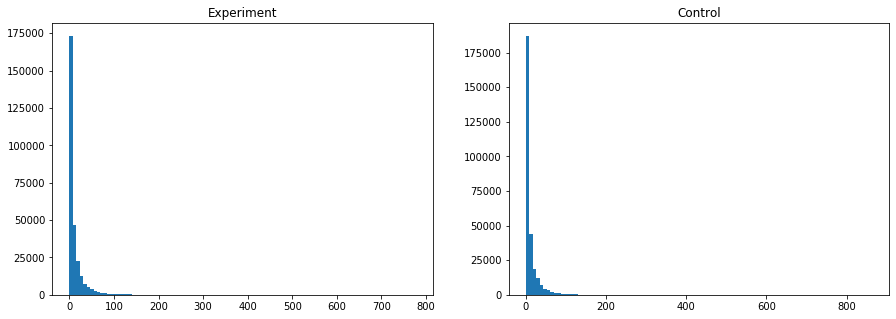

In [20]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.hist(data.n_clicks.loc[exp_ind], bins=100)
plt.title('Experiment')
plt.subplot(122)
plt.hist(data.n_clicks.loc[ctrl_ind], bins=100)
plt.title('Control');

t-критерий Стьюдента имеет множество достоинств, и потому его достаточно часто применяют в AB экспериментах. Иногда его применение может быть необоснованно из-за сильной скошенности распределения данных.

Давайте постараемся понять, когда t-критерий можно применять и как это проверить на реальных данных.

Для простоты рассмотрим одновыборочный t-критерий. Его статистика имеет вид $ Xˉ−μS2/n \frac{\bar{X} - \mu}{ \sqrt {S^2 / n}} S2/n $

$ ​Xˉ−μ​ $, то есть чтобы действительно предположения t-критерия выполнялись необходимо, чтобы:

    X¯ — среднее значение в выборке — было распределено нормально N(μ,σ2n) 
    nσ2S2  — несмещенная оценка дисперсии c масштабирующим коэффициентом — была распределена по хи-квадрат c n−1 степенями свободы χ2(n−1) 

Простое доказательство необходимости и достаточности этого требования можно посмотреть в самом последнем абзаце этого вопроса. Усвоение этого доказательства не обязательно для выполнения задания.

Оба этих предположения можно проверить с помощью бутстрепа. Ограничимся сейчас только контрольной группой, в которой распределение кликов будем называть данными в рамках данного вопроса.

Поскольку мы не знаем истинного распределения генеральной совокупности, мы можем применить бутстреп, чтобы понять, как распределены среднее значение и выборочная дисперсия. Для этого

    -Получите из данных n_boot_samples псевдовыборок.
    -По каждой из этих выборок посчитайте среднее и сумму квадратов отклонения от выборочного среднего (control_boot_chi_squared)
    -Для получившегося вектора средних значений из n_boot_samples постройте q-q plot с помощью scipy.stats.probplot для нормального распределения
    -Для получившегося вектора сумм квадратов отклонения от выборочного среднего постройте qq-plot с помощью scipy.stats.probplot для хи-квадрат распределения с помощью команды 

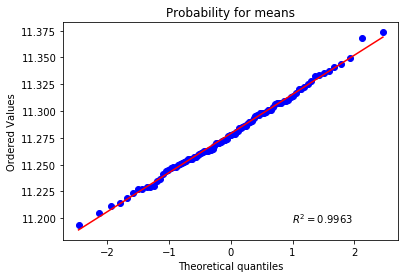

In [21]:
stats.probplot(ctrl_cl_mean, plot=plt, rvalue=True)
plt.title('Probability for means');

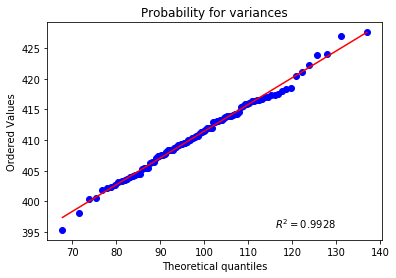

In [22]:
stats.probplot(ctrl_cl_var, plot=plt, dist='chi2', sparams=(ctrl_cl_mean.shape[0]-1), rvalue=True)
plt.title('Probability for variances');

Одним из возможных аналогов t-критерия, которым можно воспрользоваться, является тест Манна-Уитни. На достаточно обширном классе распределений он является асимптотически более эффективным, чем t-критерий, и при этом не требует параметрических предположений о характере распределения.

Разделите выборку на две части, соответствующие control и exp группам. Преобразуйте данные к виду, чтобы каждому пользователю соответствовало суммарное значение его кликов. С помощью критерия Манна-Уитни проверьте гипотезу о равенстве средних.

In [23]:
users_nclicks_exp = data.loc[exp_ind].groupby(['userID', 'browser']).sum().loc[:,'n_clicks']
users_nclicks_ctrl = data.loc[ctrl_ind].groupby(['userID', 'browser']).sum().loc[:,'n_clicks']

users_nclicks_exp.head()

userID  browser
1       2          23
3       4           3
5       4          29
7       4          54
9       4           6
Name: n_clicks, dtype: int64

In [24]:
users_nclicks_ctrl.head()

userID  browser
6       4          12
8       4           4
10      4          22
15      14          2
23      4           3
Name: n_clicks, dtype: int64

In [25]:
stats.mannwhitneyu(users_nclicks_exp, users_nclicks_ctrl, alternative='two-sided')

MannwhitneyuResult(statistic=41184125116.0, pvalue=6.247235801369629e-75)

Проверьте, для какого из браузеров наиболее сильно выражено отличие между количеством кликов в контрольной и экспериментальной группах.

Для этого примените для каждого из срезов (по каждому из уникальных значений столбца browser) критерий Манна-Уитни между control и exp группами и сделайте поправку Холма-Бонферрони на множественную проверку с $ α=0.05\alpha=0.05α=0.05 $.

In [26]:
browsers_nclicks_exp = data.loc[exp_ind].groupby(['browser', 'userID']).sum().loc[:,'n_clicks']
browsers_nclicks_ctrl = data.loc[ctrl_ind].groupby(['browser', 'userID']).sum().loc[:,'n_clicks']

In [27]:
browsers_nclicks_exp.head()

browser  userID
14       13         2
         30         4
         33        22
         45         5
         83         0
Name: n_clicks, dtype: int64

In [28]:
browsers_nclicks_ctrl.head()

browser  userID
14       15        2
         39        0
         56        4
         81        2
         88        2
Name: n_clicks, dtype: int64

In [29]:
browsers = np.unique(data.browser)
print('Unique browsers numbers: ' + str(browsers))
print('')

print('Mann-Whitney rank test without multipletest')
mw_p = np.empty(browsers.shape[0])
for i, br in enumerate(browsers):
    print('Browser #%d: ' % float(br)),
    _, mw_p[i] = stats.mannwhitneyu(browsers_nclicks_exp.loc[br, :], browsers_nclicks_ctrl.loc[br, :], alternative='two-sided')
    print('p-value = %.4f' % mw_p[i])

print('')
print('Mann-Whitney rank test with multipletest')
_, mw_p_corr, _, _ = multipletests(mw_p, alpha = 0.05, method = 'holm')
for i, br in enumerate(browsers):
    print('Browser #%d: ' % float(br)),
    print('p-value = %.4f' % mw_p_corr[i])

Unique browsers numbers: ['14' '17' '2' '20' '22' '4']

Mann-Whitney rank test without multipletest
Browser #14: 
p-value = 0.0000
Browser #17: 
p-value = 0.0748
Browser #2: 
p-value = 0.0545
Browser #20: 
p-value = 0.9073
Browser #22: 
p-value = 0.5148
Browser #4: 
p-value = 0.8152

Mann-Whitney rank test with multipletest
Browser #14: 
p-value = 0.0000
Browser #17: 
p-value = 0.2992
Browser #2: 
p-value = 0.2724
Browser #20: 
p-value = 1.0000
Browser #22: 
p-value = 1.0000
Browser #4: 
p-value = 1.0000


Для каждого браузера в каждой из двух групп (control и exp) посчитайте долю запросов, в которых пользователь не кликнул ни разу. Это можно сделать, поделив сумму значений n_nonclk_queries на сумму значений n_queries. Умножив это значение на 100, получим процент некликнутых запросов, который можно легче проинтерпретировать.

In [30]:
browsers_nonclk_q_exp = data.loc[exp_ind].groupby(['browser']).sum().loc[:,'n_nonclk_queries']
browsers_clk_q_exp = data.loc[exp_ind].groupby(['browser']).sum().loc[:,'n_queries']
browsers_nonclk_q_prop_exp = browsers_nonclk_q_exp / browsers_clk_q_exp

browsers_nonclk_q_ctrl = data.loc[ctrl_ind].groupby(['browser']).sum().loc[:,'n_nonclk_queries']
browsers_clk_q_ctrl = data.loc[ctrl_ind].groupby(['browser']).sum().loc[:,'n_queries']
browsers_nonclk_q_prop_ctrl = browsers_nonclk_q_ctrl / browsers_clk_q_ctrl

for br in browsers:
    print('Browser #%d' % float(br), end='  '),
    print(browsers_nonclk_q_prop_ctrl.loc[browsers_nonclk_q_prop_ctrl.index == br].values, end=' '),
    print('/', end=' '),
    print(browsers_nonclk_q_prop_exp.loc[browsers_nonclk_q_prop_ctrl.index == br].values)

Browser #14  [0.57590411] / [0.43755617]
Browser #17  [0.36299367] / [0.36937413]
Browser #2  [0.45962747] / [0.44982747]
Browser #20  [0.40540485] / [0.38977376]
Browser #22  [0.40593977] / [0.39853947]
Browser #4  [0.4697093] / [0.45142942]
